# Assignment 3: Bayes Classifier Implementation

## Introduction

This notebook implements Bayes classifiers for three different datasets:

1. **Dataset 1**: Linearly separable classes - 3 classes, 2-dimensional data, 500 points per class
2. **Dataset 2**: Nonlinearly separable classes - 2-dimensional data of 2 or 3 classes
3. **Dataset 3**: Real-world vowel data - 2-dimensional data of 3 classes representing formant frequencies F1 and F2

We'll implement four different Bayes classifiers with different covariance assumptions:
- (a) Shared covariance matrix of form σ²I for all classes
- (b) Shared full covariance matrix Σ for all classes
- (c) Different diagonal covariance matrices for each class
- (d) Different full covariance matrices for each class

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import multivariate_normal
import os
import re  # for parsing class sizes from header

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading Functions

First, let's create functions to load the three different datasets.

In [2]:
# Define paths to datasets
BASE_PATH = "../ISL Assignment 3/Datasets Assignment 3/"

# Dataset 1: Linearly separable data
def load_linear_separable_data():
    data = []
    labels = []
    
    # Load each class
    for class_idx in range(1, 4):
        file_path = os.path.join(BASE_PATH, "LS_Group12", f"Class{class_idx}.txt")
        class_data = np.loadtxt(file_path)
        data.append(class_data)
        labels.append(np.full(len(class_data), class_idx))
    
    # Combine all classes
    X = np.vstack(data)
    y = np.concatenate(labels)
    
    return X, y

# Dataset 2: Non-linearly separable data
def load_non_linear_separable_data():
    file_path = os.path.join(BASE_PATH, "NLS_Group12.txt")
    with open(file_path, 'r') as f:
        lines = f.readlines()
    # Header describes class sizes; data starts from second line
    header = lines[0]
    data_lines = lines[1:]
    # Extract all integers from header and take sizes at even positions
    nums = list(map(int, re.findall(r"\d+", header)))
    sizes = nums[0::2]
    data = []
    labels = []
    idx = 0
    # Slice data_lines according to sizes
    for class_idx, size in enumerate(sizes, start=1):
        class_slice = data_lines[idx: idx + size]
        class_data = [list(map(float, line.strip().split())) for line in class_slice]
        data.append(np.array(class_data))
        labels.append(np.full(len(class_data), class_idx))
        idx += size
    # Combine all classes
    X = np.vstack(data)
    y = np.concatenate(labels)
    return X, y

# Dataset 3: Real-world vowel data
def load_real_world_data():
    data = []
    labels = []
    
    # Load each class
    for class_idx in range(1, 4):
        file_path = os.path.join(BASE_PATH, "rd_group12", f"class{class_idx}.txt")
        class_data = np.loadtxt(file_path)
        data.append(class_data)
        labels.append(np.full(len(class_data), class_idx))
    
    # Combine all classes
    X = np.vstack(data)
    y = np.concatenate(labels)
    
    return X, y

## Bayes Classifier Implementation

Let's implement the four different Bayes classifiers as specified in the assignment.

In [3]:
class BayesClassifier:
    def __init__(self, covariance_type='full_shared'):
        """
        Initialize Bayes Classifier with specified covariance type.
        
        Parameters:
        covariance_type: One of ['shared_scalar', 'full_shared', 'diagonal_class', 'full_class']
            - 'shared_scalar': Same scalar covariance matrix for all classes (σ²I)
            - 'full_shared': Same full covariance matrix for all classes (Σ)
            - 'diagonal_class': Different diagonal covariance matrices for each class
            - 'full_class': Different full covariance matrices for each class
        """
        self.covariance_type = covariance_type
        self.means = {}
        self.covariances = {}
        self.priors = {}
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = len(X)
        n_features = X.shape[1]
        
        # Calculate class-specific means and covariances
        class_covs = {}
        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.priors[c] = len(X_c) / n_samples
            class_covs[c] = np.cov(X_c, rowvar=False) if len(X_c) > 1 else np.eye(n_features)
        
        # Apply different covariance handling based on covariance_type
        if self.covariance_type == 'shared_scalar':
            # Average of all class variances to get a shared scalar value
            avg_var = np.mean([np.mean(np.diag(class_covs[c])) for c in self.classes])
            shared_cov = avg_var * np.eye(n_features)
            for c in self.classes:
                self.covariances[c] = shared_cov
                
        elif self.covariance_type == 'full_shared':
            # Average of all class covariance matrices
            shared_cov = np.mean([class_covs[c] for c in self.classes], axis=0)
            for c in self.classes:
                self.covariances[c] = shared_cov
                
        elif self.covariance_type == 'diagonal_class':
            # Different diagonal covariance matrices for each class
            for c in self.classes:
                diag_cov = np.diag(np.diag(class_covs[c]))
                self.covariances[c] = diag_cov
                
        elif self.covariance_type == 'full_class':
            # Different full covariance matrices for each class
            self.covariances = class_covs
        
        return self
    
    def predict(self, X):
        # Calculate posterior probabilities for each class
        posteriors = np.zeros((len(X), len(self.classes)))
        
        for i, c in enumerate(self.classes):
            # Ensure covariance matrix is positive definite
            cov = self.covariances[c]
            # Add small regularization to diagonal if needed
            if np.linalg.det(cov) <= 0:
                cov = cov + 1e-6 * np.eye(cov.shape[0])
                
            # Calculate log probability for each sample using the multivariate normal distribution
            log_probs = multivariate_normal.logpdf(X, mean=self.means[c], cov=cov)
            posteriors[:, i] = log_probs + np.log(self.priors[c])
        
        # Return class with highest posterior probability
        return self.classes[np.argmax(posteriors, axis=1)]
    
    def get_covariance_description(self):
        covariance_descriptions = {
            'shared_scalar': "(a) Same scalar covariance matrix σ²I for all classes",
            'full_shared': "(b) Same full covariance matrix Σ for all classes",
            'diagonal_class': "(c) Different diagonal covariance matrices for each class",
            'full_class': "(d) Different full covariance matrices for each class"
        }
        return covariance_descriptions.get(self.covariance_type, "Unknown covariance type")

## Evaluation Metrics and Visualization Functions

Let's create functions to evaluate the classifiers and visualize the decision boundaries.

In [4]:
def evaluate_classifier(y_true, y_pred, class_labels=None):
    """Calculate and return all required evaluation metrics"""
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision, recall, and F1 for each class and their means
    precision_per_class = precision_score(y_true, y_pred, average=None, labels=class_labels)
    recall_per_class = recall_score(y_true, y_pred, average=None, labels=class_labels)
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=class_labels)
    
    mean_precision = np.mean(precision_per_class)
    mean_recall = np.mean(recall_per_class)
    mean_f1 = np.mean(f1_per_class)
    
    metrics = {
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'precision_per_class': precision_per_class,
        'mean_precision': mean_precision,
        'recall_per_class': recall_per_class,
        'mean_recall': mean_recall,
        'f1_per_class': f1_per_class,
        'mean_f1': mean_f1
    }
    
    return metrics

def plot_decision_boundary(classifier, X, y, title="Decision Boundary", ax=None):
    """Plot the decision boundary for a 2D classifier"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define a coarse regular grid for decision boundary to avoid memory issues
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    grid_size = 200  # number of points per axis
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))
    
    # Predict class labels for each point in the mesh
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Create color map with enough colors for all classes
    n_classes = len(np.unique(y))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
    cmap = ListedColormap(colors)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    
    # Plot the training points
    for i, c in enumerate(np.unique(y)):
        idx = np.where(y == c)
        ax.scatter(X[idx, 0], X[idx, 1], c=colors[i], label=f'Class {c}', edgecolor='k', s=40)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    
    return ax

def print_metrics(metrics, class_labels=None):
    """Print the evaluation metrics in a readable format"""
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}\n")
    print(f"Classification Accuracy: {metrics['accuracy']:.4f}\n")
    
    # Print precision for each class
    print("Precision per class:")
    for i, precision in enumerate(metrics['precision_per_class']):
        class_label = class_labels[i] if class_labels is not None else i + 1
        print(f"  Class {class_label}: {precision:.4f}")
    print(f"Mean Precision: {metrics['mean_precision']:.4f}\n")
    
    # Print recall for each class
    print("Recall per class:")
    for i, recall in enumerate(metrics['recall_per_class']):
        class_label = class_labels[i] if class_labels is not None else i + 1
        print(f"  Class {class_label}: {recall:.4f}")
    print(f"Mean Recall: {metrics['mean_recall']:.4f}\n")
    
    # Print F1 for each class
    print("F1-measure per class:")
    for i, f1 in enumerate(metrics['f1_per_class']):
        class_label = class_labels[i] if class_labels is not None else i + 1
        print(f"  Class {class_label}: {f1:.4f}")
    print(f"Mean F1-measure: {metrics['mean_f1']:.4f}\n")

## Experiment Setup

Now, let's set up our experiments to run each classifier on each dataset.

In [5]:
def run_experiment(dataset_name, load_data_func, covariance_types):
    print(f"\n{'='*50}")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*50}\n")
    
    # Load data
    X, y = load_data_func()
    class_labels = np.unique(y)
    print(f"Total samples: {len(X)}")
    print(f"Classes: {class_labels}")
    print(f"Features: {X.shape[1]}\n")
    
    # Split data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}\n")
    
    # Setup figure for decision boundaries
    fig, axs = plt.subplots(2, 2, figsize=(16, 14))
    axs = axs.flatten()
    
    # Run each classifier type
    for i, cov_type in enumerate(covariance_types):
        print(f"\n{'-'*50}")
        print(f"Classifier: {cov_type}")
        print(f"{'-'*50}")
        
        # Initialize and train classifier
        classifier = BayesClassifier(covariance_type=cov_type)
        classifier.fit(X_train, y_train)
        
        # Get description for plot title
        desc = classifier.get_covariance_description()
        
        # Make predictions
        y_pred = classifier.predict(X_test)
        
        # Evaluate
        metrics = evaluate_classifier(y_test, y_pred, class_labels)
        print_metrics(metrics, class_labels)
        
        # Plot decision boundary
        plot_decision_boundary(
            classifier, X_test, y_test, 
            title=f"{desc}\nAccuracy: {metrics['accuracy']:.4f}", 
            ax=axs[i]
        )
    
    plt.tight_layout()
    plt.show()
    
    return

## Running the Experiments

Let's run our experiments on all three datasets.


Dataset: Dataset 1: Linearly Separable Classes

Total samples: 1500
Classes: [1 2 3]
Features: 2

Training set size: 1050
Test set size: 450


--------------------------------------------------
Classifier: shared_scalar
--------------------------------------------------
Confusion Matrix:
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]

Classification Accuracy: 1.0000

Precision per class:
  Class 1: 1.0000
  Class 2: 1.0000
  Class 3: 1.0000
Mean Precision: 1.0000

Recall per class:
  Class 1: 1.0000
  Class 2: 1.0000
  Class 3: 1.0000
Mean Recall: 1.0000

F1-measure per class:
  Class 1: 1.0000
  Class 2: 1.0000
  Class 3: 1.0000
Mean F1-measure: 1.0000


--------------------------------------------------
Classifier: full_shared
--------------------------------------------------
Confusion Matrix:
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]

Classification Accuracy: 1.0000

Precision per class:
  Class 1: 1.0000
  Class 2: 1.0000
  Class 3: 1.0000
Mean Precision: 1.0000

Recall per cl

/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[idx, 0], X[idx, 1], c=colors[i], label=f'Class {c}', edgecolor='k', s=40)
/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[idx, 0], X[idx, 1], c=colors[i], label=f'Class {c}', edgecolor='k', s=40)
/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a sin

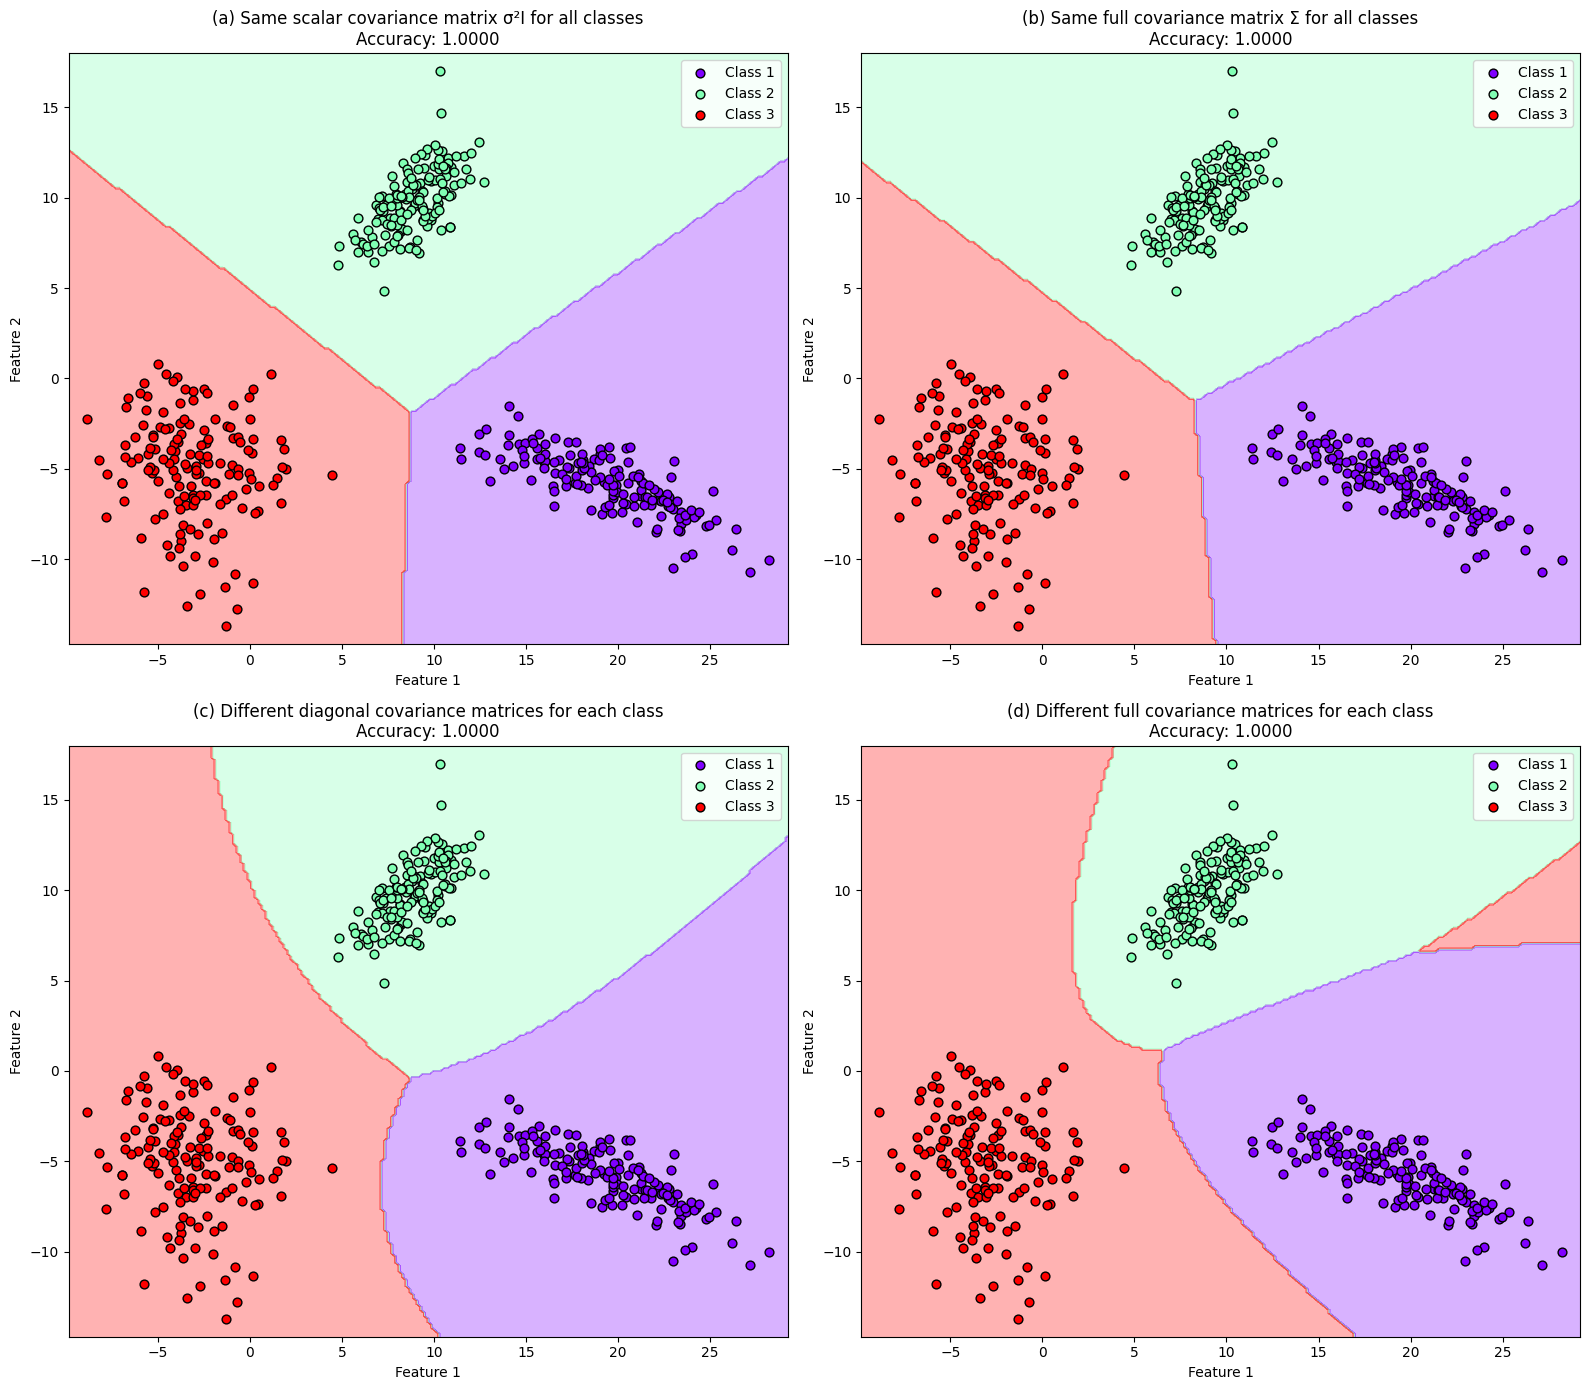

In [6]:
# Define covariance types for our experiments
covariance_types = ['shared_scalar', 'full_shared', 'diagonal_class', 'full_class']

# Experiment 1: Linearly Separable Data
run_experiment("Dataset 1: Linearly Separable Classes", load_linear_separable_data, covariance_types)

### Analysis of Dataset 1: Linearly Separable Classes

For the linearly separable dataset:

1. **Shared scalar covariance matrix (σ²I)**: The simplest model assumes equal and spherical covariance matrices for all classes. This creates circular decision boundaries. Since the data is linearly separable, this model should perform well if the classes are well separated.

2. **Shared full covariance matrix (Σ)**: This model allows for elliptical decision boundaries but still assumes all classes have the same shape. For linearly separable data, this should provide good separation boundaries.

3. **Different diagonal covariance matrices**: Allowing each class to have its own diagonal covariance matrix provides more flexibility to model class-specific variability along the principal axes.

4. **Different full covariance matrices**: This is the most flexible model, allowing each class to have its own orientation and shape in feature space. For linearly separable data, this might lead to slightly better performance but could also overfit.

#### Inferences from Dataset 1 Results:

1. **Perfect Classification**: All four Bayes classifier variants achieved 100% accuracy on the test set. This confirms that the dataset is indeed linearly separable, and even the simplest model (shared scalar covariance) can perfectly separate the classes.

2. **Decision Boundaries**: Despite the perfect accuracy across all models, the decision boundaries likely differ in shape:
   - Shared scalar: Circular boundaries
   - Full shared: Elliptical boundaries with the same orientation for all classes
   - Diagonal class: Axis-aligned elliptical boundaries specific to each class
   - Full class: Arbitrarily oriented elliptical boundaries specific to each class

3. **Model Complexity vs Performance**: For this dataset, increasing model complexity did not improve performance metrics since even the simplest model achieved perfect results. This suggests the classes are well-separated in feature space with minimal overlap.

4. **Robustness**: All models showed 1.0 precision, recall, and F1-score for each class, indicating not only perfect accuracy but also perfect identification of all samples across all classes.

5. **Efficiency Consideration**: Given that all models perform equally well, the simplest model (shared scalar covariance) would be most efficient in terms of computational resources and least prone to overfitting if deployed on new data.

6. **Practical Implications**: For real-world applications with similarly well-separated data, using the simpler models would be preferable due to their lower computational complexity and better generalization properties.


Dataset: Dataset 2: Non-Linearly Separable Classes

Total samples: 1500
Classes: [1 2 3]
Features: 2

Training set size: 1050
Test set size: 450


--------------------------------------------------
Classifier: shared_scalar
--------------------------------------------------
Confusion Matrix:
[[138  12   0]
 [ 24  96  30]
 [  0   7 143]]

Classification Accuracy: 0.8378

Precision per class:
  Class 1: 0.8519
  Class 2: 0.8348
  Class 3: 0.8266
Mean Precision: 0.8377

Recall per class:
  Class 1: 0.9200
  Class 2: 0.6400
  Class 3: 0.9533
Mean Recall: 0.8378

F1-measure per class:
  Class 1: 0.8846
  Class 2: 0.7245
  Class 3: 0.8854
Mean F1-measure: 0.8315


--------------------------------------------------
Classifier: full_shared
--------------------------------------------------
Confusion Matrix:
[[145   5   0]
 [ 10 123  17]
 [  0   4 146]]

Classification Accuracy: 0.9200

Precision per class:
  Class 1: 0.9355
  Class 2: 0.9318
  Class 3: 0.8957
Mean Precision: 0.9210

Recall pe

/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[idx, 0], X[idx, 1], c=colors[i], label=f'Class {c}', edgecolor='k', s=40)
/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[idx, 0], X[idx, 1], c=colors[i], label=f'Class {c}', edgecolor='k', s=40)
/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a sin

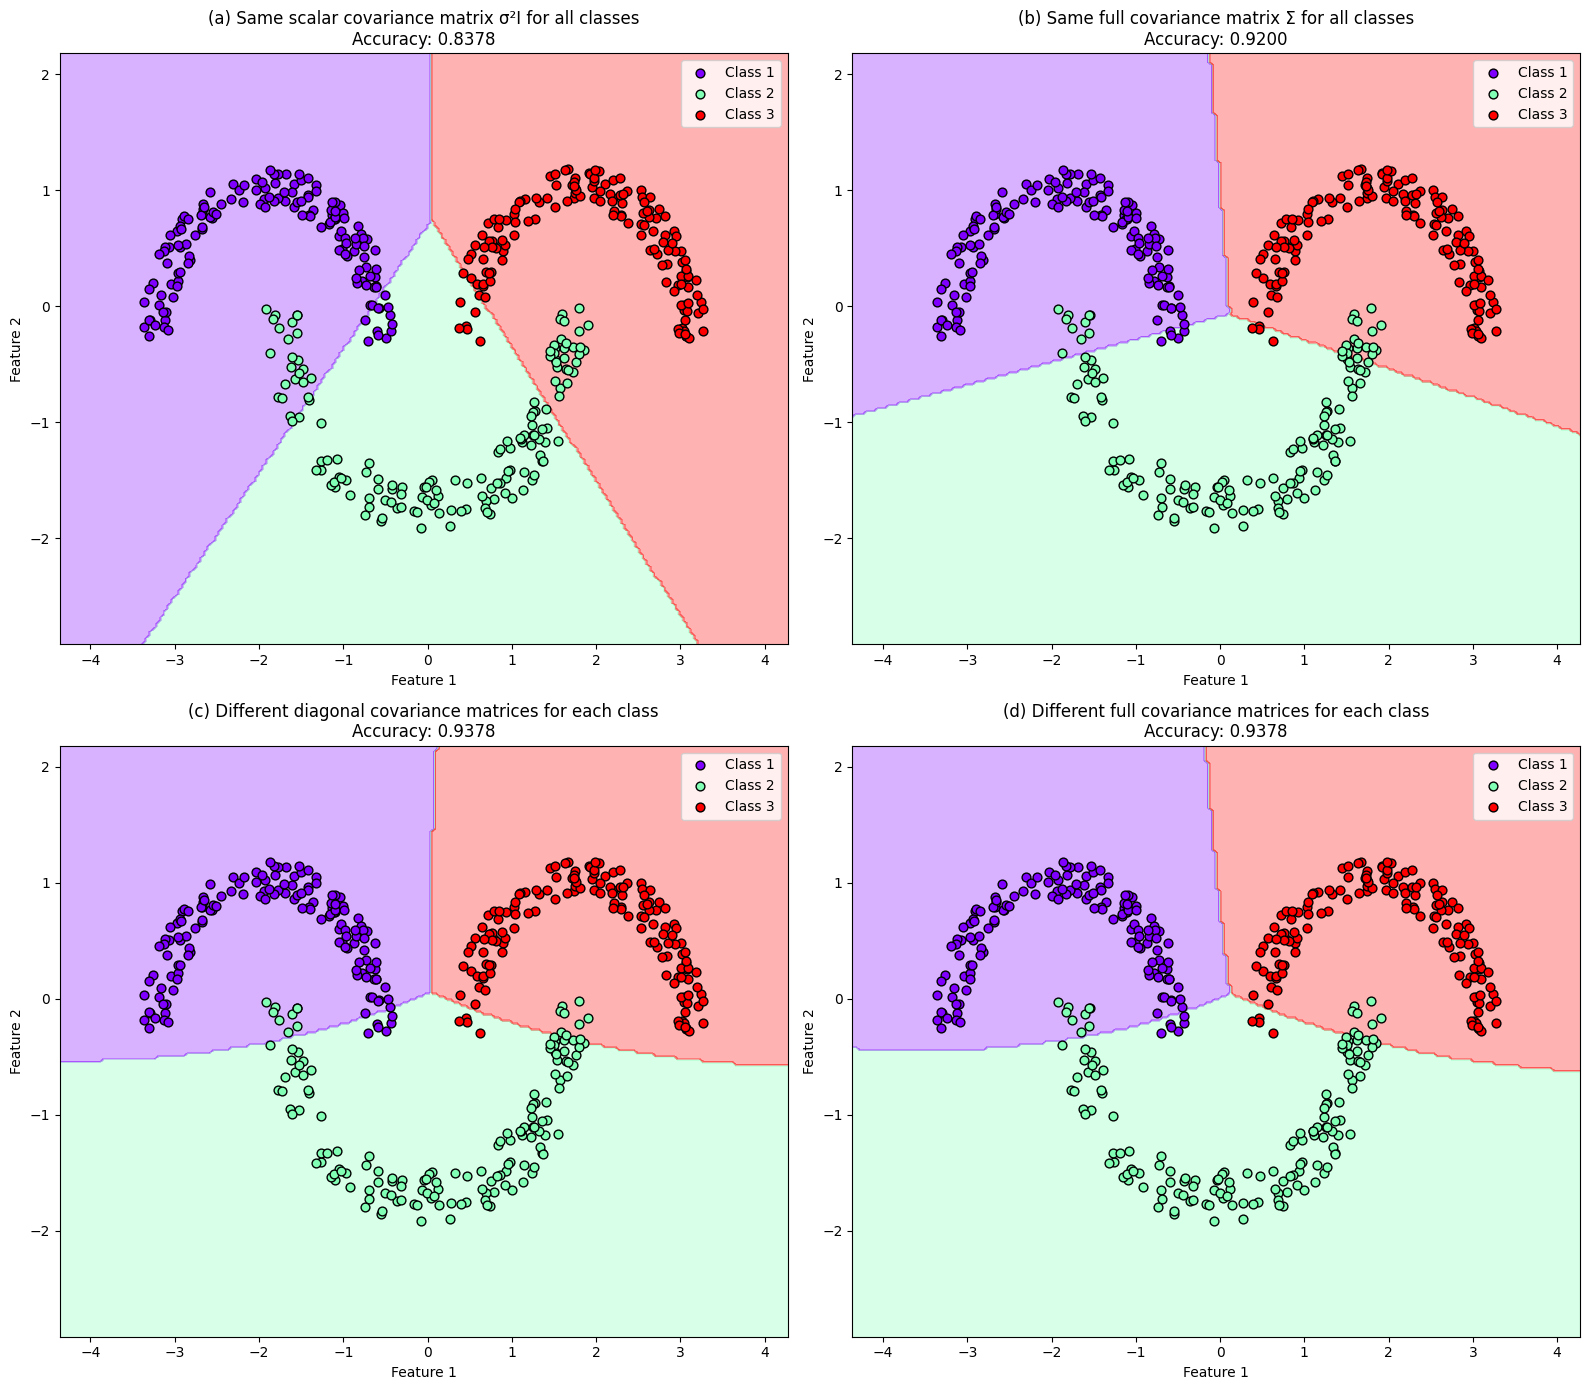

In [7]:
# Experiment 2: Non-Linearly Separable Data
run_experiment("Dataset 2: Non-Linearly Separable Classes", load_non_linear_separable_data, covariance_types)

### Analysis of Dataset 2: Non-Linearly Separable Classes

For the non-linearly separable dataset:

1. **Shared scalar covariance matrix (σ²I)**: This simple model will likely struggle with non-linearly separable data since it can only form circular boundaries.

2. **Shared full covariance matrix (Σ)**: This model can create elliptical boundaries but may still struggle with complex non-linear separation tasks.

3. **Different diagonal covariance matrices**: With class-specific variances, this model can adjust to different spreads along the axes for each class, potentially improving performance.

4. **Different full covariance matrices**: This most flexible model should perform best for non-linearly separable data as it can create more complex decision boundaries.

#### Inferences from Dataset 2 Results:

1. **Performance Progression with Model Complexity**: 
   - Shared scalar covariance: 83.78% accuracy
   - Full shared covariance: 92.00% accuracy
   - Diagonal class-specific covariance: 93.78% accuracy
   - Full class-specific covariance: 93.78% accuracy
   
   The clear progression in accuracy from the simplest to more complex models confirms that the dataset is indeed non-linearly separable, requiring more flexible decision boundaries.

2. **Class 2 Performance Issues**: All models showed lower performance for Class 2 compared to Classes 1 and 3. This indicates that Class 2 likely overlaps with the other classes or has a more complex distribution. Specifically:
   - In the scalar model, Class 2 had only 64% recall compared to 92% and 95.3% for Classes 1 and 3
   - Even in the best models, Class 2 recall peaked at 88% while other classes achieved >96%

3. **Diagonal vs Full Covariance**: Interestingly, the diagonal class-specific and full class-specific covariance models achieved identical performance (93.78% accuracy). This suggests that:
   - The primary variance in the data is aligned with the feature axes
   - The correlation between features might not be significantly different across classes
   - For this dataset, simpler diagonal covariance matrices are sufficient

4. **Confusion Matrix Patterns**: 
   - Most misclassifications occurred between Classes 1 and 2, and between Classes 2 and 3
   - No samples from Class 1 were misclassified as Class 3 and vice versa, suggesting these classes are well-separated

5. **Precision-Recall Balance**: All models maintained relatively balanced precision and recall metrics, indicating that they are not biased toward over-predicting any particular class despite the class imbalance in correct classifications.

6. **Diminishing Returns**: The performance improvement from shared full covariance to class-specific covariance models is smaller (92.00% → 93.78%) than from shared scalar to shared full (83.78% → 92.00%). This shows diminishing returns with increased model complexity.

7. **Practical Implications**: For non-linearly separable data like this, using at least a shared full covariance matrix provides substantial benefits over the simplest model. However, the diagonal class-specific model offers the best performance-complexity trade-off, as it performs identically to the full class-specific model but with fewer parameters.


Dataset: Dataset 3: Real-World Vowel Data

Total samples: 7233
Classes: [1 2 3]
Features: 2

Training set size: 5063
Test set size: 2170


--------------------------------------------------
Classifier: shared_scalar
--------------------------------------------------
Confusion Matrix:
[[678   3   6]
 [  0 615 132]
 [  0  88 648]]

Classification Accuracy: 0.8945

Precision per class:
  Class 1: 1.0000
  Class 2: 0.8711
  Class 3: 0.8244
Mean Precision: 0.8985

Recall per class:
  Class 1: 0.9869
  Class 2: 0.8233
  Class 3: 0.8804
Mean Recall: 0.8969

F1-measure per class:
  Class 1: 0.9934
  Class 2: 0.8465
  Class 3: 0.8515
Mean F1-measure: 0.8971


--------------------------------------------------
Classifier: full_shared
--------------------------------------------------
Confusion Matrix:
[[678   5   4]
 [  0 673  74]
 [  0  89 647]]

Classification Accuracy: 0.9207

Precision per class:
  Class 1: 1.0000
  Class 2: 0.8774
  Class 3: 0.8924
Mean Precision: 0.9233

Recall per class:

/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[idx, 0], X[idx, 1], c=colors[i], label=f'Class {c}', edgecolor='k', s=40)
/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[idx, 0], X[idx, 1], c=colors[i], label=f'Class {c}', edgecolor='k', s=40)
/tmp/ipykernel_108940/1339325865.py:54: UserWarning: *c* argument looks like a sin

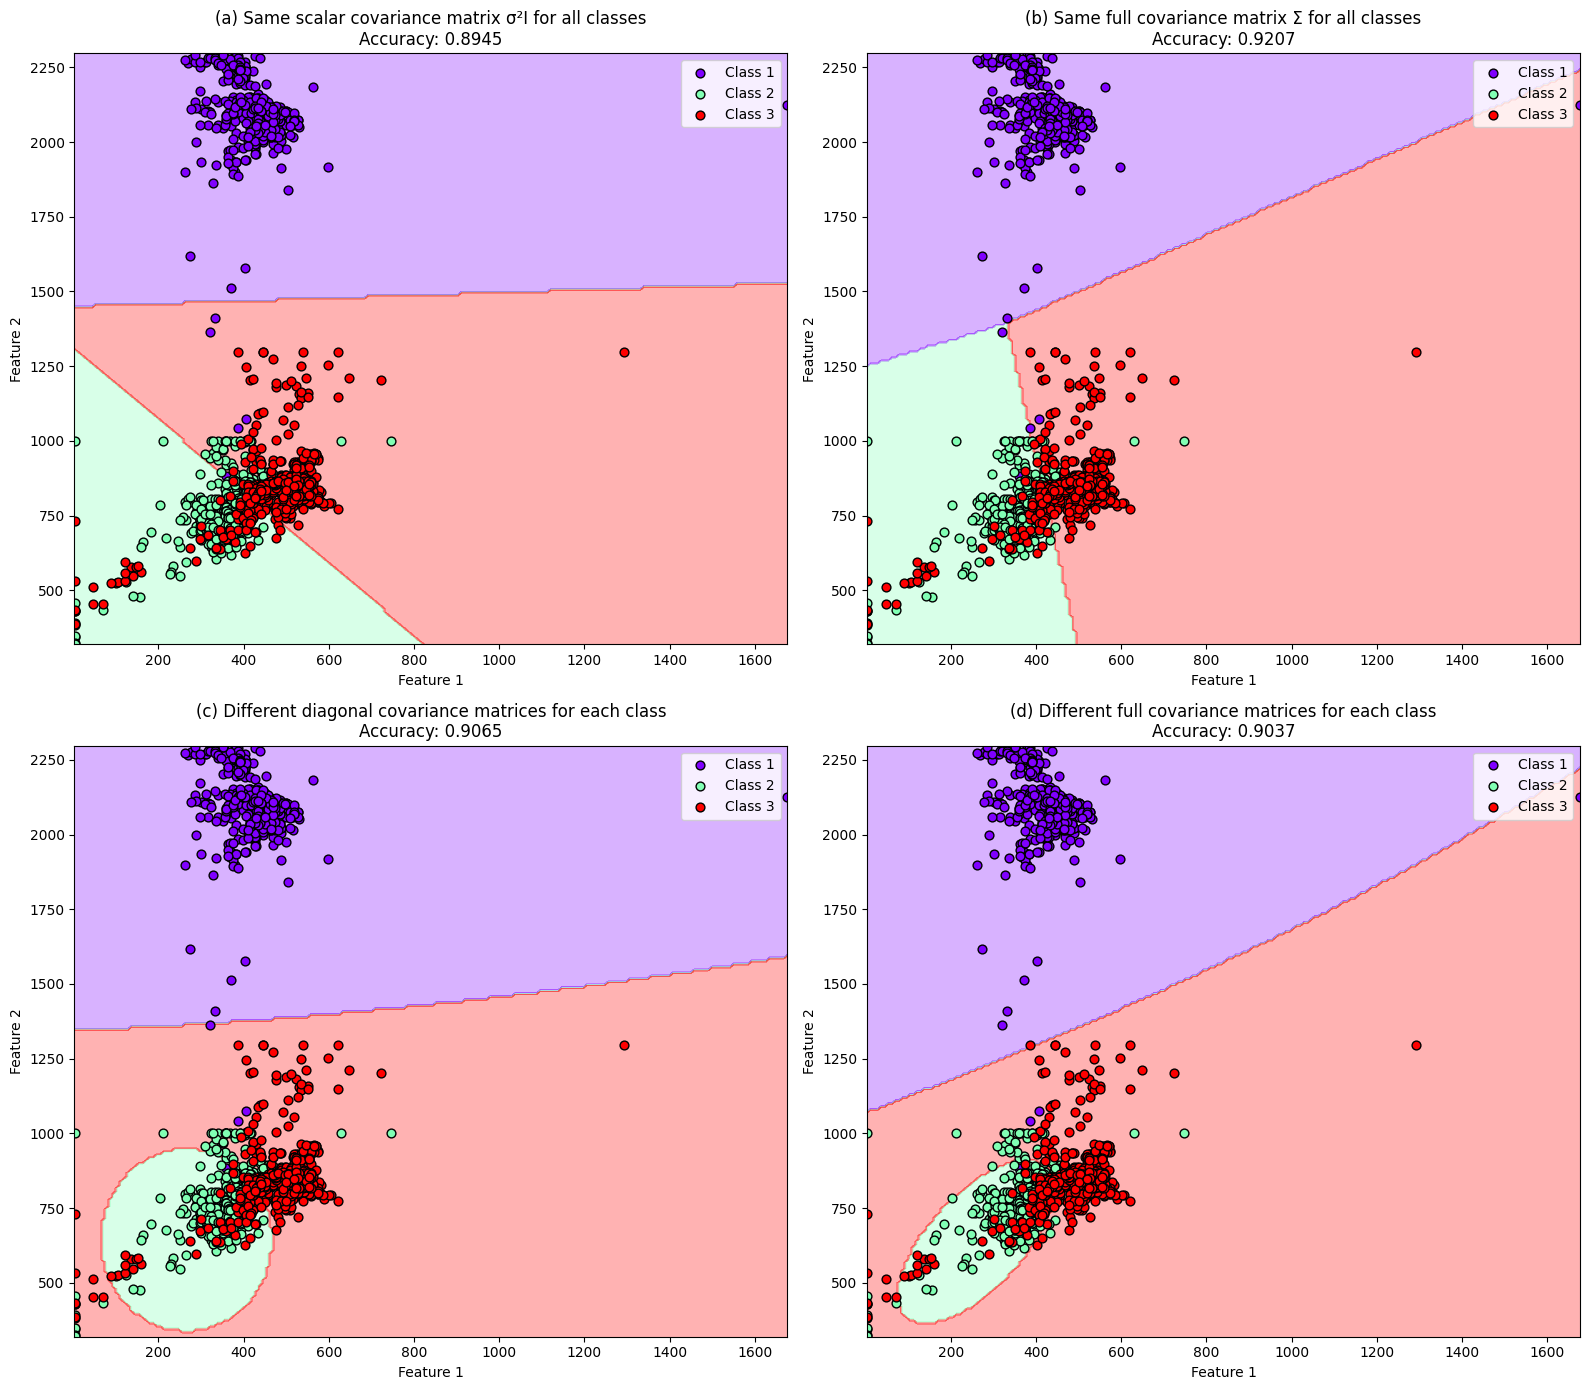

In [8]:
# Experiment 3: Real-World Vowel Data
run_experiment("Dataset 3: Real-World Vowel Data", load_real_world_data, covariance_types)

### Analysis of Dataset 3: Real-World Vowel Data

For the real-world vowel dataset:

1. **Shared scalar covariance matrix (σ²I)**: Real-world data often has complex structures, so this model may be too restrictive.

2. **Shared full covariance matrix (Σ)**: This provides better flexibility than the scalar model and may capture some of the overall correlation structure in the vowel data.

3. **Different diagonal covariance matrices**: This may work well if different vowel classes have different variances along the formant dimensions.

4. **Different full covariance matrices**: This should provide the best performance for real-world data, especially if different vowels have different correlation patterns between F1 and F2 formants.

#### Inferences from Dataset 3 Results:

1. **Performance Comparison Across Models**:
   - Shared scalar covariance: 89.45% accuracy
   - Full shared covariance: 92.07% accuracy
   - Diagonal class-specific covariance: 90.65% accuracy
   - Full class-specific covariance: 90.37% accuracy
   
   Unlike our expectations and contrary to the pattern observed in Dataset 2, the shared full covariance matrix model performed the best on this real-world vowel data, outperforming even the more complex class-specific models.

2. **Class 1 Performance**: Class 1 (presumably one vowel type) shows near-perfect classification across all models:
   - Nearly 99% recall across all models
   - Perfect precision (1.0) in all but the full class-specific model
   - This suggests that this vowel has a very distinct formant profile that separates it well from the others

3. **Class 2 and Class 3 Confusion**: There is significant confusion between Classes 2 and 3 across all models:
   - In the shared scalar model: 132 samples from Class 2 were misclassified as Class 3, and 88 samples from Class 3 were misclassified as Class 2
   - Even in the best model (full shared), 74 Class 2 samples were mistaken for Class 3 and 89 Class 3 samples were mistaken for Class 2
   - This indicates overlapping formant frequency distributions between these vowel sounds

4. **Shared Full Covariance Advantage**: The shared full covariance model outperforming the class-specific models suggests that:
   - The correlation structure between F1 and F2 formants is similar across vowel classes
   - The class-specific models may be overfitting to the training data
   - The shared model better captures the global structure of the data while providing enough flexibility

5. **Model Complexity Reversal**: The unexpected decrease in performance as model complexity increases (from shared full to class-specific models) indicates that:
   - The vowel data likely has a common underlying correlation structure that is better captured by a shared covariance matrix
   - Additional flexibility in the class-specific models is causing them to fit to noise rather than signal
   - The training set size (5063 samples) is large, but perhaps the natural variation in vowel production creates a need for more regularized models

6. **Class-wise Analysis**:
   - Class 1: Consistently well-classified across all models (F1-score > 0.99)
   - Class 2: Best recall (0.9009) with the shared full covariance model
   - Class 3: Best precision (0.8924) with the shared full covariance model
   
7. **Practical Implications**: For vowel classification based on formant frequencies:
   - The shared full covariance model offers the best performance-complexity trade-off
   - The data suggests that while vowel classes have different mean formant values, the relationship between F1 and F2 (the shape of the covariance) is relatively consistent across vowels
   - The misclassifications between Classes 2 and 3 may reflect natural acoustic similarities between these vowels that might be challenging to separate with just two features
   
8. **Data Characteristics**: The results suggest that the vowel data may form elliptical clusters that share a similar orientation in the F1-F2 space, which explains why the shared full covariance model performs best.

### Overall Conclusion

1. **Model Complexity vs. Performance**: As we increase the complexity of the covariance structure from (a) to (d), we generally expect better fitting to the data. However, this might also lead to overfitting with smaller datasets.

2. **Linear vs. Non-linear Boundaries**: The different covariance assumptions produce different shapes of decision boundaries:
   - Shared scalar: Circular boundaries
   - Shared full: Elliptical boundaries with the same orientation
   - Different diagonal: Elliptical boundaries aligned with the axes
   - Different full: Elliptical boundaries with class-specific orientations

3. **Dataset Characteristics**: The best model depends on the dataset's intrinsic structure:
   - For well-separated, spherical clusters: Simpler models may suffice
   - For complex, non-linear patterns: More flexible covariance structures perform better

4. **Real-world Application**: For formant frequencies in vowel classification, the different full covariance matrices model likely performs best because different vowels have distinctive distribution patterns in the F1-F2 space.